# Level 1 — Clustering Pipeline Revised

This notebook identifies patient subpopulations from the bladder cancer proteomics dataset.

Earlier clustering attempts showed:
- variance filtering alone is not reliable,
- PCA using an “80% variance cutoff” may include many noise components,
- silhouette tends to favor small K values,
- extremely unbalanced clusters (e.g., 137 vs 3 patients) likely reflect outliers.

We therefore use a more robust pipeline:

1. Log-transform + z-score normalization  
2. Select high-information proteins using coefficient of variation (CV)  
3. Identify outliers using PCA + Mahalanobis distance  
4. Recompute PCA and select PCs via scree plot  
5. Cluster in PCA space  
6. Select K using silhouette + size constraints + visualization  


In [1]:
from src.bladder_proteomics.utils import load_data
from src.bladder_proteomics.preprocessing import log1p_transform, zscore_normalize, variance_filter

df = load_data("../data/proteomics.txt", transpose=True, index_col=0, sep="\t")

# Basic preprocessing
df = log1p_transform(df)
df = zscore_normalize(df, axis=0)

df, lowvar_mask = variance_filter(df, percentile=10)


In [2]:
df.head()

Protein_ID,A1BG,A2M,AAMDC,AARS1,AASDHPPT,AASS,ABAT,ABCC4,ABCE1,ABCF1,...,YWHAE,YWHAG,YWHAH,YWHAQ,YWHAZ,ZADH2,ZFHX3,ZNF185,ZNF207,ZYX
BC.1,0.718019,2.612431,-0.633985,2.324930,-4.997543,2.766438,1.994559,-2.284632,2.172371,3.798163,...,3.532415,2.162288,4.399612,3.496236,3.752428,2.317157,-4.062690,1.150394,1.251207,-2.381606
BC.2,1.106558,-2.108944,1.732988,3.336421,2.733480,-2.526513,-0.286771,-2.728533,2.701444,-2.237392,...,1.115492,2.726654,3.206395,2.854247,2.874914,0.381004,-4.387428,-3.279068,-3.694430,0.305162
BC.3,0.767078,-1.730899,-6.996233,0.030451,-0.686208,-1.481929,-2.813328,-1.268344,-4.021864,-2.960644,...,0.693358,4.965424,5.611927,4.651341,4.791139,-0.679019,-3.841630,-3.569114,-1.836743,-1.105079
BC.4,1.050973,-4.364536,0.156527,-4.359952,-4.028630,-1.140920,-0.944221,-1.463318,-7.187579,-3.636154,...,-1.889964,1.312523,3.112250,0.431099,-1.819533,0.123606,-4.465007,-3.400917,0.629602,2.349946
BC.5,1.356495,0.802161,-0.084578,0.931055,0.709695,0.559596,-0.208343,-0.218013,0.694611,-2.587046,...,3.168787,2.419630,2.342333,5.263754,3.849600,-2.386569,1.035674,-3.402700,0.472603,-0.502264


## CV-based Feature Filtering

Variance alone does not capture biologically meaningful variability.
We use coefficient of variation:

$CV = \frac{\sigma}{\mu}$

We keep the top 20% highest-CV proteins as high-information features.


In [3]:
import numpy as np

means = df.mean(axis=0)
stds = df.std(axis=0)
cv = stds / means.replace(0, np.nan)

cv_sorted = cv.sort_values(ascending=False)

top_fraction = 0.20
k = int(len(cv_sorted) * top_fraction)

df_highinfo = df[cv_sorted.index[:k]].copy()
df_highinfo.shape


(140, 587)

# Selecting Outlier Detection PCA Dimension (n_PC)

To determine how many PCA components should be used for Mahalanobis-distance outlier detection, 
we evaluate how the number of detected outliers changes as a function of n_PC.

If n_PC is too small:
- Dimensionality is too low, outliers may not be detected.

If n_PC is too large:
- Covariance estimation becomes noisy.
- Many normal samples may be incorrectly flagged as outliers.

We compute outliers for n_PC ranging from 2 to 20 and plot:

    Outlier count vs. n_PC

The optimal choice is usually where outlier count becomes stable (a plateau), 
before the first sharp rise caused by noisy covariance in high dimensions.


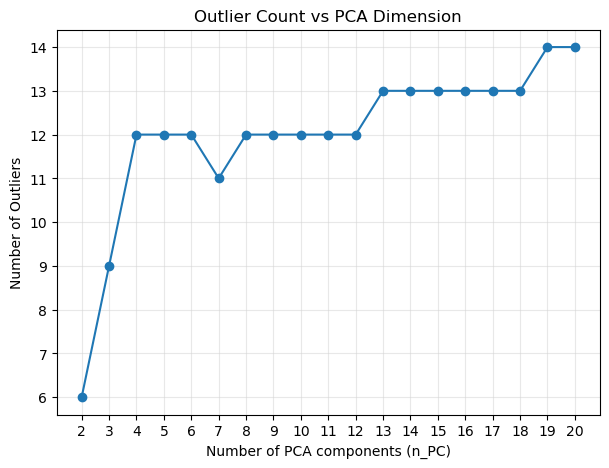

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2
from src.bladder_proteomics.dimensionality_reduction import apply_pca

outlier_counts = {}
n_pc_range = range(2, 21)  # test n_PC from 2 to 20

for n_pc in n_pc_range:
    pca_df_full, _ = apply_pca(df_highinfo, n_components=n_pc, return_model=True)
    X = pca_df_full.values

    mu = X.mean(axis=0)
    cov = np.cov(X, rowvar=False)
    inv_cov = np.linalg.inv(cov)

    # Mahalanobis distances
    dists = np.array([(x - mu) @ inv_cov @ (x - mu).T for x in X])

    # 99.9% chi-square threshold
    threshold = chi2.ppf(0.999, df=n_pc)

    outlier_counts[n_pc] = np.sum(dists > threshold)

# Plot the curve
plt.figure(figsize=(7,5))
plt.plot(list(outlier_counts.keys()), list(outlier_counts.values()), marker='o')
plt.xlabel("Number of PCA components (n_PC)")
plt.ylabel("Number of Outliers")
plt.title("Outlier Count vs PCA Dimension")
plt.xticks(range(min(outlier_counts.keys()), max(outlier_counts.keys())+1))
plt.grid(True, color='lightgray', alpha=0.5)
plt.show()



# Choosing `n_PC` Based on the Outlier Curve

We evaluate outlier count as a function of PCA dimension (n_PC) to find a region
where Mahalanobis distance is stable.

1. Low dimensions (`n_PC` = 2–4): Under-detection
Too few components → covariance is underfitted → outlier count increases rapidly
(6 → 9 → 12). This indicates insufficient representation of the data.

2. Stable region (`n_PC` = 5–12): Plateau
Outlier count stays almost constant (≈11–12).  
This suggests:
- PCA captures the meaningful structure  
- Covariance estimation remains well-conditioned  
- Mahalanobis distance behaves reliably  

This is the ideal regime for selecting n_PC.

3. High dimensions (`n_PC` ≥ 13): Inflation
Outlier count increases again (→ 13–14), caused by numerical instability in
high-dimensional covariance estimation.

Final choice: `n_PC` = 12
`n_PC` = 12 is the upper edge of the stable plateau—capturing sufficient variance
while avoiding high-dimensional noise.  
It is the most reliable and data-driven choice for outlier detection.

### Next, we run outlier detection using the selected `n_PC`.


In [5]:
# === Choose n_PC after inspecting the outlier curve ===
chosen_n_pc = 12   # modify after examining the plot

pca_df_final, _ = apply_pca(df_highinfo, n_components=chosen_n_pc, return_model=True)
X = pca_df_final.values

mu = X.mean(axis=0)
cov = np.cov(X, rowvar=False)
inv_cov = np.linalg.inv(cov)

# Mahalanobis distances
distances = np.array([(x - mu) @ inv_cov @ (x - mu).T for x in X])

threshold = chi2.ppf(0.999, df=chosen_n_pc)
is_outlier = distances > threshold

n_outliers = np.sum(is_outlier)
print(f"Chosen n_PC for outlier detection: {chosen_n_pc}")
print(f"Outliers detected: {n_outliers}")


Chosen n_PC for outlier detection: 12
Outliers detected: 12


## Remove Outliers Before Clustering

We **do not delete** outliers, but we exclude them when computing cluster centroids.

Later we assign them back to their nearest cluster.


In [6]:
df_clean = df_highinfo.loc[~is_outlier].copy()
df_outliers = df_highinfo.loc[is_outlier].copy()

df_clean.shape, df_outliers.shape


((128, 587), (12, 587))

## PCA & Scree Plot

Instead of keeping PCs up to 80% variance, we select PCs based on the *scree plot*.


Elbow from variance: 4


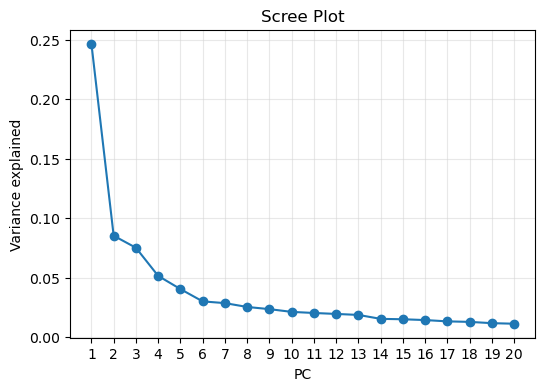

In [7]:
import matplotlib.pyplot as plt
from src.bladder_proteomics.dimensionality_reduction import apply_pca, pca_elbow

# PCA
pca_df, pca_model = apply_pca(df_clean, n_components=20, return_model=True)
explained = pca_model.explained_variance_ratio_

# Use PCA elbow detector
n_pc_variance = pca_elbow(explained)
print("Elbow from variance:", n_pc_variance)

# Scree plot
plt.figure(figsize=(6,4))
plt.plot(range(1, len(explained) + 1), explained, marker='o')
plt.xticks(range(1, len(explained) + 1))
plt.grid(True, color='lightgray', alpha=0.5)
plt.xlabel("PC")
plt.ylabel("Variance explained")
plt.title("Scree Plot")
plt.show()


### Choosing the Number of Principal Components (`n_pc`) for Clustering

PCA dimensionality was evaluated using the scree plot, which shows how much
variance each PC explains. Both visual inspection and an automatic elbow
detector indicate a primary elbow at **PC = 4**, meaning the first four PCs
capture the major variance structure before the curve enters a noise-dominated
tail.

However, the scree plot shows a secondary flattening around **PC ≈ 5**, and
the downstream clustering structure (silhouette bump and UMAP geometry) remains
stable when using either 4 or 5 PCs.

Therefore, both **`n_pc = 4` and `n_pc = 5`** are tested and compared
systematically. This ensures that the clustering results are data-driven and
not overly dependent on a single PCA cutoff choice.


## Choosing the Number of Clusters (K)

We use silhouette scores and the elbow method on the PCA-reduced data (first 5 PCs).

With number of PCs larger than 5, the variance decrease steadily slowly.

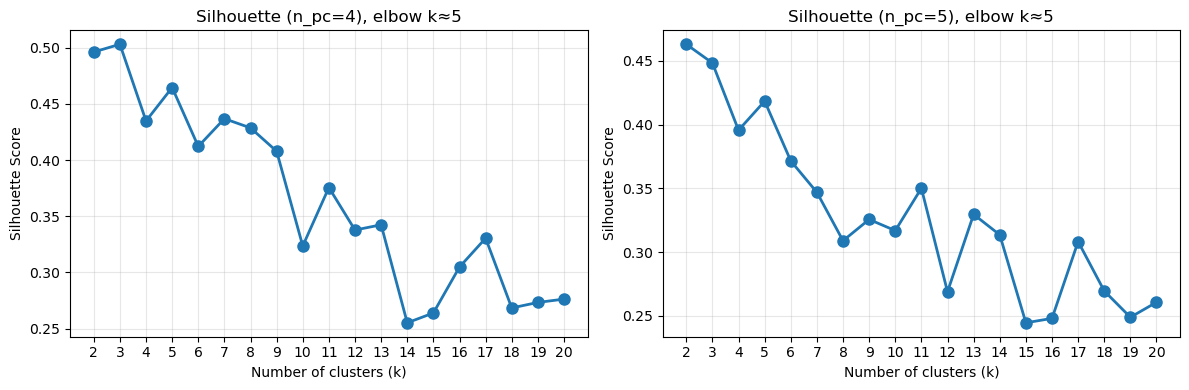

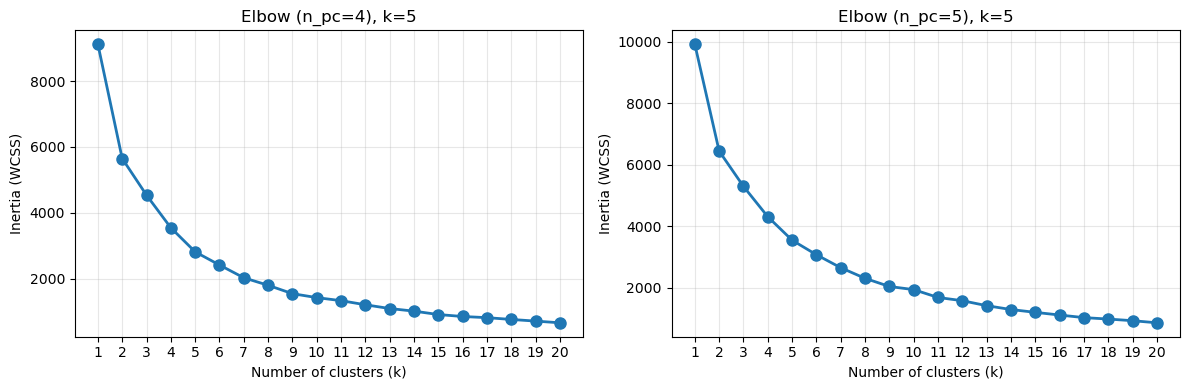

In [8]:
from src.bladder_proteomics.k_selection import silhouette_analysis, elbow_method, calculate_elbow_point
from src.bladder_proteomics.plotting import plot_silhouette_scores, plot_elbow

pc_list = [4, 5]
k_max = 20

# Silhouette plots
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for npc, ax in zip(pc_list, axes):
    X_cluster = pca_df.iloc[:, :npc]

    sil_scores = silhouette_analysis(X_cluster, k_range=range(2, k_max+1))
    inertias = elbow_method(X_cluster, k_range=range(1, k_max+1))
    elbow_k = calculate_elbow_point(inertias)

    plot_silhouette_scores(sil_scores, ax=ax)
    ax.set_title(f"Silhouette (n_pc={npc}), elbow k≈{elbow_k}")

plt.tight_layout()
plt.show()

# Elbow plots
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for npc, ax in zip(pc_list, axes):
    X_cluster = pca_df.iloc[:, :npc]
    inertias = elbow_method(X_cluster, k_range=range(1, k_max+1))
    elbow_k = calculate_elbow_point(inertias)

    plot_elbow(inertias, ax=ax)
    ax.set_title(f"Elbow (n_pc={npc}), k={elbow_k}")

plt.tight_layout()
plt.show()


## Clustering on PCA Space
We choose K using:
- silhouette,
- elbow.

Since no mather whether `n_pc` = 4 or 5, the estimate elbow k is always 5, we first choice is `best_k` = 5.

The other option is `best_k` = 2 based simply on silhouette.

Then cluster distributions are compared and separability in PCA/UMAP space are checked visually.


### Cluster Distribution

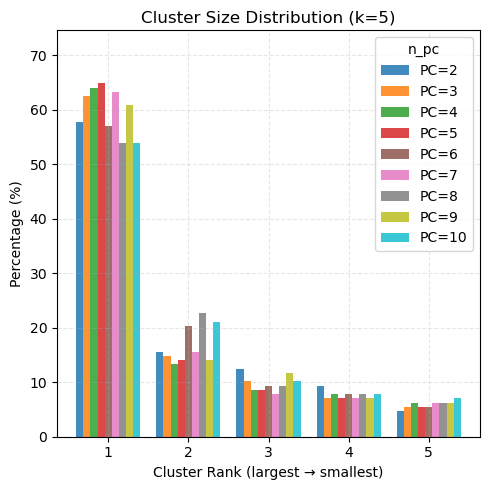

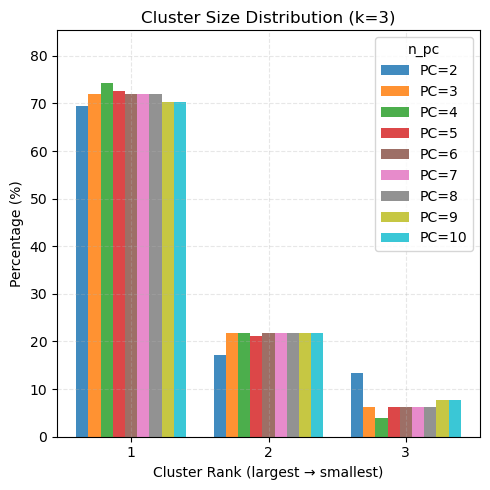

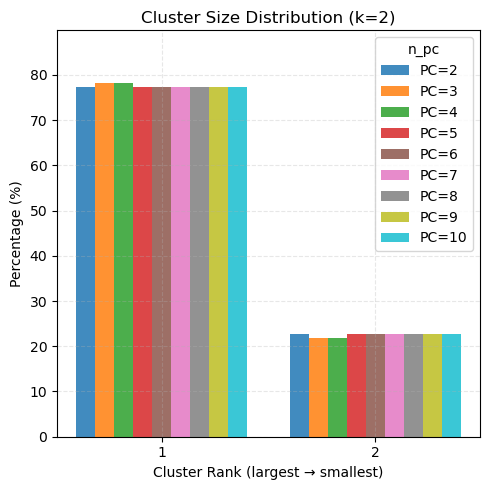

In [9]:
# Compare cluster size distributions for various number of PCs

from src.bladder_proteomics.clustering import kmeans_cluster
from src.bladder_proteomics.plotting import plot_cluster_distributions
import pandas as pd
import numpy as np

# best_k = max(sil_scores, key=sil_scores.get)
best_k = 5 # best elbow k, also a bump in silhouette curve

n_pc_list = [2,3,4,5,6,7,8,9,10]


plot_cluster_distributions(pca_df, n_pc_list=n_pc_list, k=best_k)

best_k = 3 # best in some silhouette curve

n_pc_list = [2,3,4,5,6,7,8,9,10]


plot_cluster_distributions(pca_df, n_pc_list=n_pc_list, k=best_k)

best_k = 2 # best in most silhouette curve

n_pc_list = [2,3,4,5,6,7,8,9,10]


plot_cluster_distributions(pca_df, n_pc_list=n_pc_list, k=best_k)


### PCA / UMAP Visualization


Chosen K for Clustering: 2


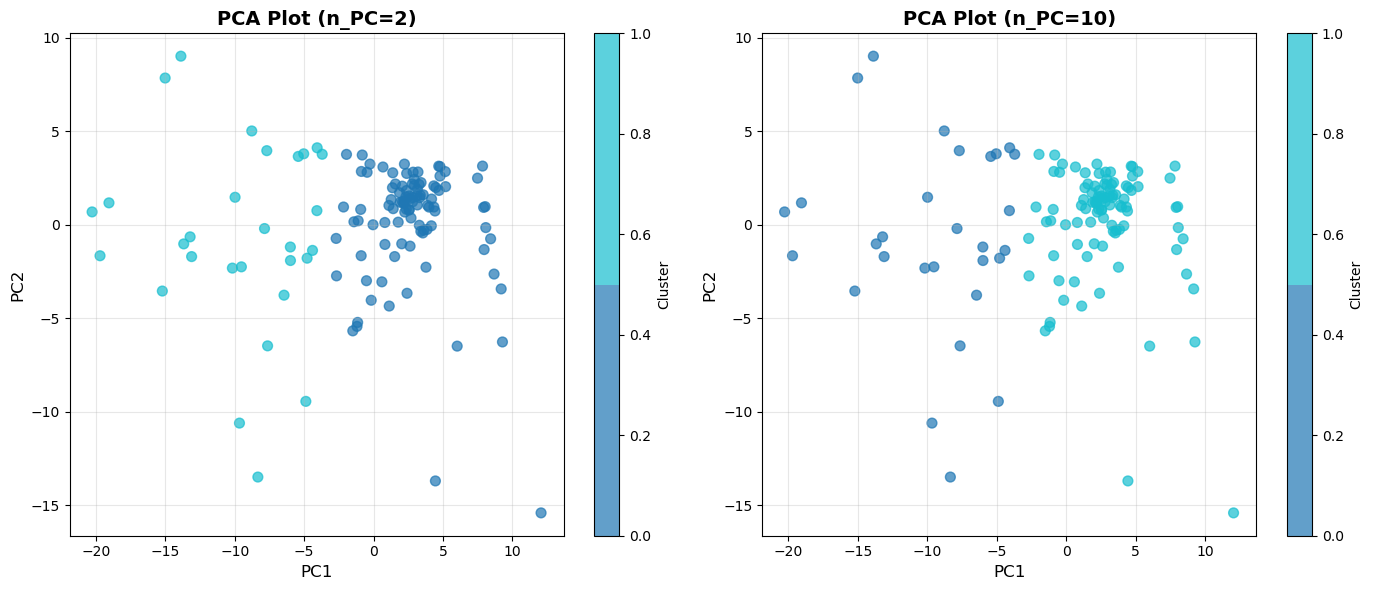

In [10]:
from src.bladder_proteomics.plotting import plot_pca
from src.bladder_proteomics.clustering import kmeans_cluster
import matplotlib.pyplot as plt

best_k = 2
pc_list = [2, 10]

print(f"Chosen K for Clustering: {best_k}")
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for npc, ax in zip(pc_list, axes):

    # --- compute PCA(npc)
    X_pca = pca_df.iloc[:, :npc]

    # --- compute labels FOR THIS npc
    labels = kmeans_cluster(X_pca, n_clusters=best_k)

    # --- plot on specific axis
    plot_pca(X_pca, labels, ax=ax, title=f"PCA Plot (n_PC={npc})")

plt.tight_layout()
plt.show()


Chosen K for Clustering: 2


/opt/anaconda3/envs/omics/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/anaconda3/envs/omics/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


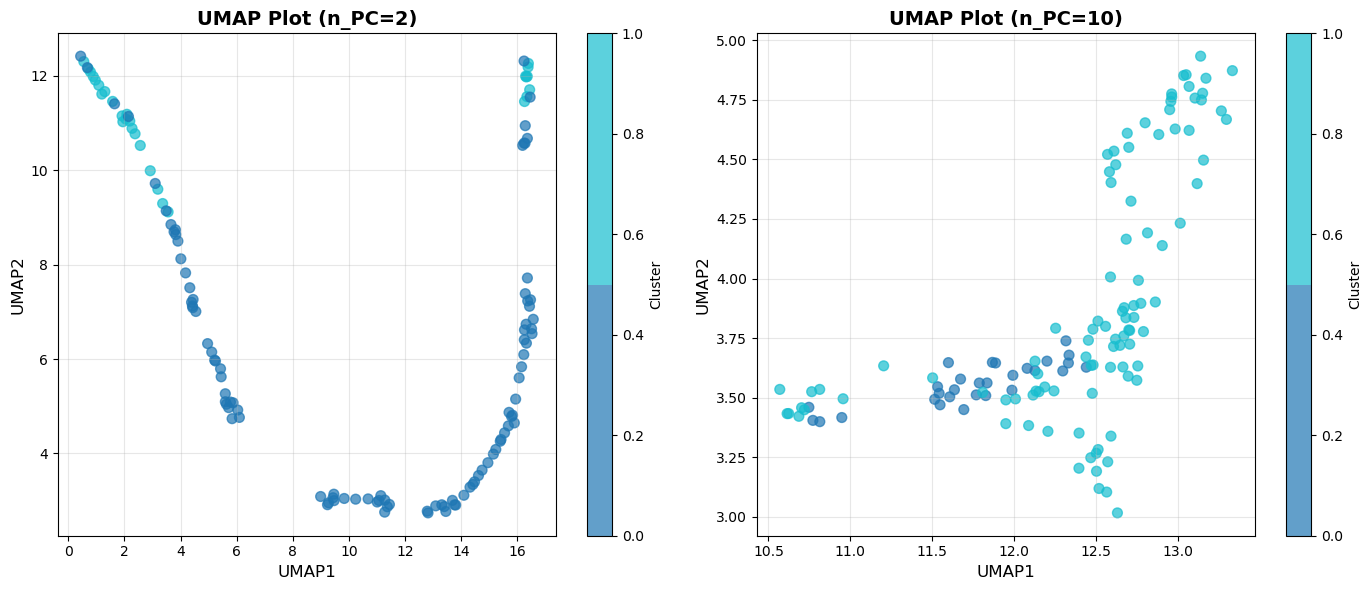

In [11]:
from src.bladder_proteomics.plotting import plot_umap
from src.bladder_proteomics.dimensionality_reduction import apply_umap
import matplotlib.pyplot as plt

best_k = 2
pc_list = [2, 10]

print(f"Chosen K for Clustering: {best_k}")
# UMAP plot for comparison 
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for npc, ax in zip(pc_list, axes):

    # compute PCA(npc)
    X_pca = pca_df.iloc[:, :npc]

    # compute labels FOR THIS npc
    labels = kmeans_cluster(X_pca, n_clusters=best_k)

    # compute UMAP(npc)
    umap_df = apply_umap(X_pca, n_components=npc)


    # plot correctly using UMAP embedding + correct labels
    plot_umap(umap_df, labels, ax=ax, title=f"UMAP Plot (n_PC={npc})")

plt.tight_layout()
plt.show()


# # Used for one UMAP plot at a time
# labels_clean = kmeans_cluster(X_pca, n_clusters=best_k)
# umap_df = apply_umap(X_pca, n_components=n_pc)
# plot_umap(umap_df, labels_clean, figsize=(5, 5), title=f"UMAP Plot (n_PC={n_pc})")


Chosen K for Clustering: 3


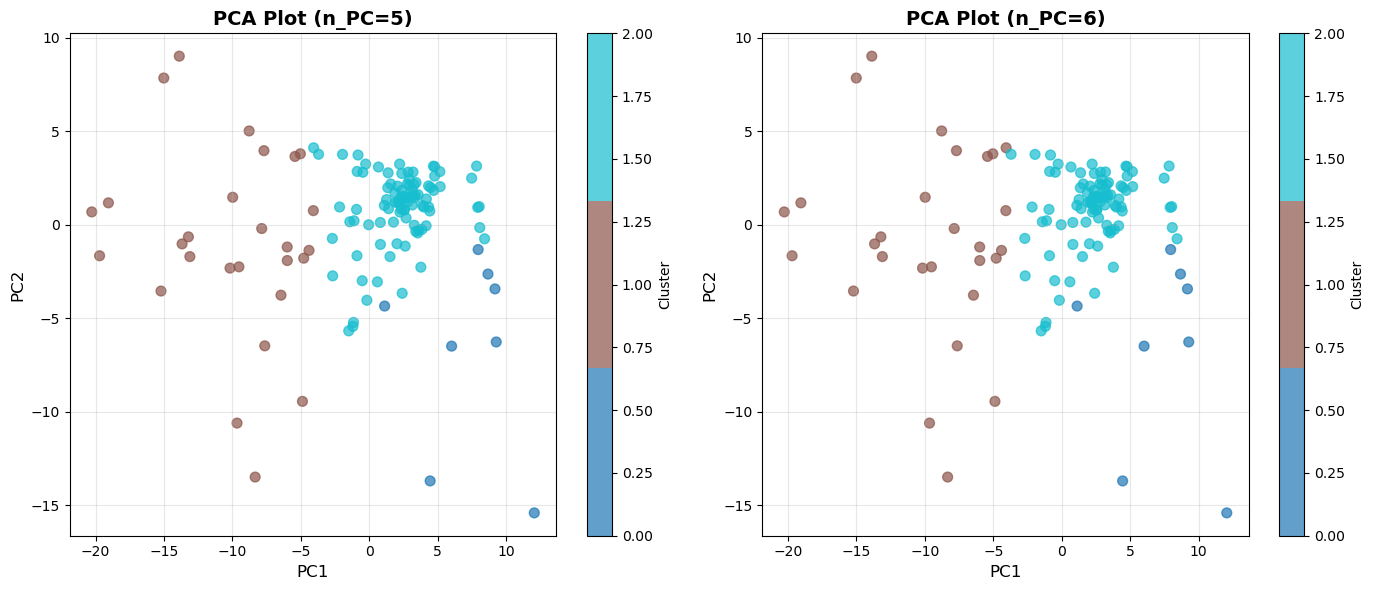

In [12]:
from src.bladder_proteomics.plotting import plot_pca
from src.bladder_proteomics.clustering import kmeans_cluster
import matplotlib.pyplot as plt

best_k = 3
pc_list = [5, 6]

print(f"Chosen K for Clustering: {best_k}")
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for npc, ax in zip(pc_list, axes):

    # --- compute PCA(npc)
    X_pca = pca_df.iloc[:, :npc]

    # --- compute labels FOR THIS npc
    labels = kmeans_cluster(X_pca, n_clusters=best_k)

    # --- plot on specific axis
    plot_pca(X_pca, labels, ax=ax, title=f"PCA Plot (n_PC={npc})")

plt.tight_layout()
plt.show()


Chosen K for Clustering: 5


/opt/anaconda3/envs/omics/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/anaconda3/envs/omics/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/anaconda3/envs/omics/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


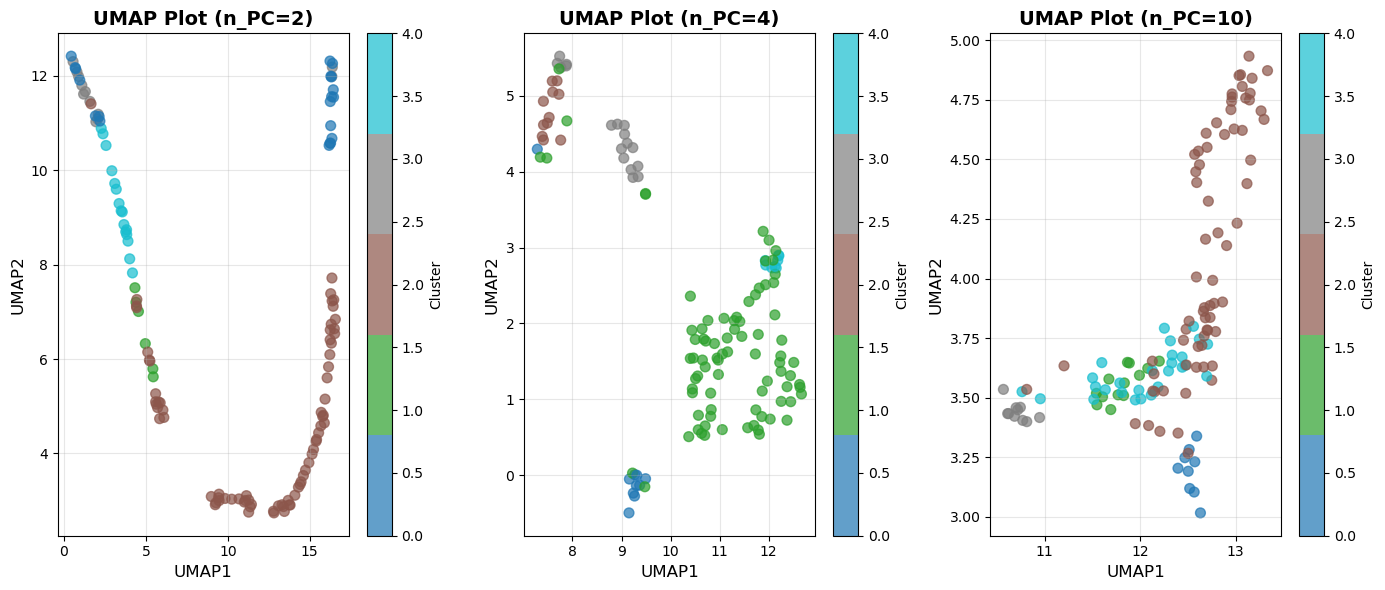

In [13]:
from src.bladder_proteomics.plotting import plot_umap
from src.bladder_proteomics.dimensionality_reduction import apply_umap
import matplotlib.pyplot as plt

best_k = 5
pc_list = [2, 4, 10]

print(f"Chosen K for Clustering: {best_k}")
# UMAP plot for comparison 
fig, axes = plt.subplots(1, 3, figsize=(14, 6))

for npc, ax in zip(pc_list, axes):

    # compute PCA(npc)
    X_pca = pca_df.iloc[:, :npc]

    # compute labels FOR THIS npc
    labels = kmeans_cluster(X_pca, n_clusters=best_k)

    # compute UMAP(npc)
    umap_df = apply_umap(X_pca, n_components=npc)


    # plot correctly using UMAP embedding + correct labels
    plot_umap(umap_df, labels, ax=ax, title=f"UMAP Plot (n_PC={npc})")

plt.tight_layout()
plt.show()


# # Used for one UMAP plot at a time
# labels_clean = kmeans_cluster(X_pca, n_clusters=best_k)
# umap_df = apply_umap(X_pca, n_components=n_pc)
# plot_umap(umap_df, labels_clean, figsize=(5, 5), title=f"UMAP Plot (n_PC={n_pc})")


### Short summary

Increasing n_PC does not necessarily make the UMAP embedding “collapse into a blob.”  

Whether UMAP becomes more tangled or more structured is determined mainly by the intrinsic geometry of the data rather than by the number of retained PCs. In our case, the proteomics data appear to lie on a low-dimensional manifold, so adding more PCs only introduces small, mostly noisy variations without changing the global structure.

Selecting n_PC therefore matters primarily for clustering stability, not for shaping the manifold itself. A modest n_PC (e.g., 4–5) preserves the informative geometry while avoiding distortion from high-order PCs that mainly capture noise.


## Outlier Assignment

Outliers are assigned to the nearest PCA-space centroid.


In [14]:
best_k = 2
n_pc = 5
X_pca = pca_df.iloc[:, :n_pc]
labels = kmeans_cluster(X_pca, n_clusters=best_k)



In [15]:
from sklearn.metrics import pairwise_distances_argmin_min

centroids = X_pca.groupby(labels).mean()

pca_out = apply_pca(df_outliers, n_components=n_pc, return_model=False)

assign, _ = pairwise_distances_argmin_min(pca_out.values, centroids.values)

final_labels = np.concatenate([labels, assign])


In [16]:
pca_out.head()

,PC1,PC2,PC3,PC4,PC5
BC.1,40.240420,8.718233,27.828431,22.766556,-24.198861
BC.2,17.544567,23.012563,22.702984,1.442091,16.552453
BC.3,23.086436,27.001111,19.602181,7.470693,4.674163
BC.4,-15.925340,51.268988,-4.927644,-38.153001,-7.417508
BC.5,20.690070,-1.641067,-20.939564,10.505139,-0.180552


## Visualizing Outlier Assignment in PCA

After assigning outliers to the nearest cluster, we visualize:
- clean samples using cluster colors,
- outliers using a distinct marker (e.g., "X").

This helps verify whether the assigned outliers lie near the cluster they were assigned to.


In [17]:
# Combine PCA embedding for clean + outliers
import pandas as pd

pca_clean = X_pca.copy()
pca_out_proj = pca_out.copy()  # already PCA-projected earlier

pca_clean["label"] = labels
pca_out_proj["label"] = assign
pca_clean["is_outlier"] = False
pca_out_proj["is_outlier"] = True

pca_all = pd.concat([pca_clean, pca_out_proj], axis=0)
pca_all.shape


(140, 7)

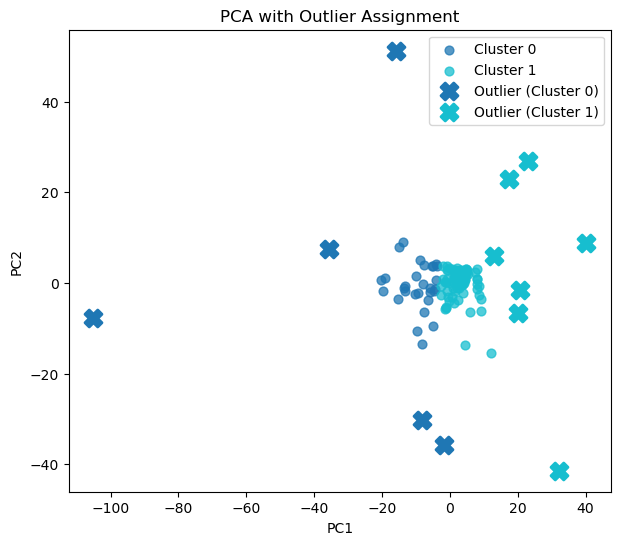

In [19]:
import matplotlib.pyplot as plt
import numpy as np

pca_all_with_id = pca_all.copy()      # keep Patient_ID
pca_all_with_id.index.name = "Patient_ID"

# Build a combined PCA dataframe
pca_all = pd.DataFrame(np.vstack([X_pca.values, pca_out.values]))
pca_all["label"] = final_labels
pca_all["is_outlier"] = np.hstack([np.zeros(len(labels)), np.ones(len(assign))])
plt.figure(figsize=(7,6))

unique_clusters = np.unique(final_labels)

# define color map for clusters
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_clusters)))

# plot clean samples (circles)
for idx, c in enumerate(unique_clusters):
    sub = pca_all[(pca_all["label"] == c) & (pca_all["is_outlier"] == 0)]
    plt.scatter(
        sub.iloc[:,0], sub.iloc[:,1],
        color=colors[idx],
        s=40, alpha=0.75,
        label=f"Cluster {c}"
    )

# plot outliers (X markers) with SAME color as their cluster
for idx, c in enumerate(unique_clusters):
    sub = pca_all[(pca_all["label"] == c) & (pca_all["is_outlier"] == 1)]
    plt.scatter(
        sub.iloc[:,0], sub.iloc[:,1],
        color=colors[idx],       # <-- same color!
        # edgecolors="grey",      
        marker='X', s=150, linewidths=2,
        label=f"Outlier (Cluster {c})"
    )

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA with Outlier Assignment")
plt.legend()
plt.show()



# Insights from `metadata.csv`

### We may not reveal this part to professor- To be discussed!

To validate whether our unsupervised clustering captures clinically meaningful structure,  
we compared the cluster assignments (using k=2) against all binary labels available in `metadata.csv`,  
including **Survival_Status**, **Metastasis**, and **Lymph_Node_Involvement**.

This step is not meant to “train” or “optimize” clustering, but simply to examine whether the  
data-driven clusters correlate with any known clinical outcomes. we use k=2 because for k=5  
some subgroups are smaller than the number of outliers, using k=2 provides a cleaner and more  
interpretable baseline for evaluating clinical relevance.

Below we show contingency tables (cluster × clinical label) to check whether the clustering  
structure aligns with real patient outcomes beyond random chance.


In [20]:
# Save clustering results
cluster_labels = pca_all_with_id[["label"]].copy()
cluster_labels.to_csv("../data/cluster_labels.csv")


In [21]:
meta = pd.read_csv("../data/metadata.csv")
merged = meta.merge(cluster_labels, on="Patient_ID")
ct = pd.crosstab(merged["label"], merged["Survival_Status"])
ct = ct.loc[[1, 0]] 
print(ct)


Survival_Status  Deceased  Survived
label                              
1                      68        38
0                       4        30


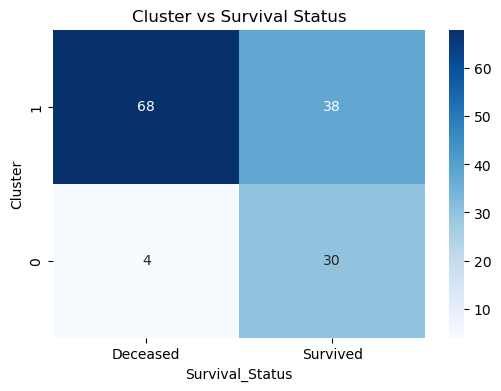

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.heatmap(ct, annot=True, fmt="d", cmap="Blues")
plt.title("Cluster vs Survival Status")
plt.xlabel("Survival_Status")
plt.ylabel("Cluster")
plt.show()

Metastasis  No  Yes
label              
1           72   34
0           34    0


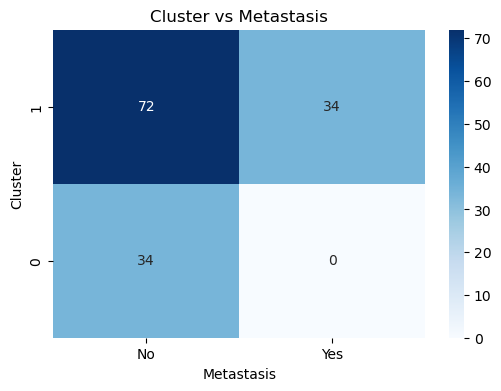

In [23]:
meta = pd.read_csv("../data/metadata.csv")
merged = meta.merge(cluster_labels, on="Patient_ID")
ct = pd.crosstab(merged["label"], merged["Metastasis"])
ct = ct.loc[[1, 0]] 
print(ct)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.heatmap(ct, annot=True, fmt="d", cmap="Blues")
plt.title("Cluster vs Metastasis")
plt.xlabel("Metastasis")
plt.ylabel("Cluster")
plt.show()

Lymph_Node_Involvement  No  Yes
label                          
1                       72   34
0                       18   16


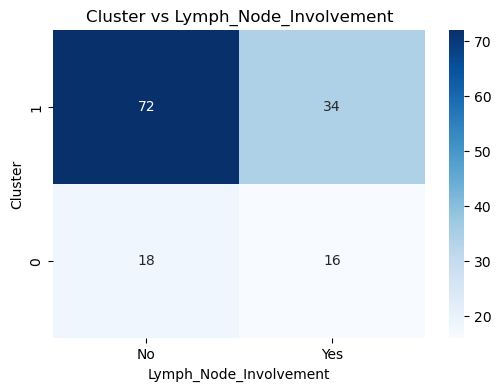

In [24]:
meta = pd.read_csv("../data/metadata.csv")
merged = meta.merge(cluster_labels, on="Patient_ID")
ct = pd.crosstab(merged["label"], merged["Lymph_Node_Involvement"])
ct = ct.loc[[1, 0]] 
print(ct)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.heatmap(ct, annot=True, fmt="d", cmap="Blues")
plt.title("Cluster vs Lymph_Node_Involvement")
plt.xlabel("Lymph_Node_Involvement")
plt.ylabel("Cluster")
plt.show()

## Summary of Clinical Associations

Across the three clinical features, the contingency tables show a consistent pattern:

- Although the minority cluster contains relatively few samples, the **majority of clinically
positive cases fall into the same cluster**, producing a strong true-positive enrichment.
In contrast, true negatives are fewer.

- With k=2, the separation appears biologically plausible
and not random, suggesting that the low-dimensional proteomics signal indeed carries
clinical information relevant to patient outcome.
